In [1]:
import os
import glob
import time
from datetime import datetime
from ppo import PPO
from creaternddemand import *
from invenv import InvEnv
import torch
import numpy as np


################################### Training ###################################
def train():
    print("============================================================================================")


    has_continuous_action_space = False # continuous action space; else discrete

    max_ep_len = 364                   # max timesteps in one episode
    max_training_timesteps = int(364*3000)   # break training loop if timeteps > max_training_timesteps

    print_freq = max_ep_len * 10        # print avg reward in the interval (in num timesteps)

    action_std = 0.6            # starting std for action distribution (Multivariate Normal)
    action_std_decay_rate = 0.03       # linearly decay action_std (action_std = action_std - action_std_decay_rate)
    min_action_std = 0.03               # minimum action_std (stop decay after action_std <= min_action_std)
    action_std_decay_freq = int(1e5)  # action_std decay frequency (in num timesteps)
    #####################################################

    ## Note : print/log frequencies should be > than max_ep_len

    ################ PPO hyperparameters ################
    update_timestep = max_ep_len/2       # update policy every n timesteps
    K_epochs = 20               # update policy for K epochs in one PPO update

    eps_clip = 0.2          # clip parameter for PPO
    gamma = 0.99            # discount factor

    lr_actor = 0.00005       # learning rate for actor network
    lr_critic = 0.0001       # learning rate for critic network

    random_seed = 0         # set random seed if required (0 = no random seed)
    #####################################################

    state_dim = 7
    action_dim = 21

    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    ################# training procedure ################

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    print("============================================================================================")


    # printing and logging variables
    print_running_reward = 0
    print_running_episodes = 0

    time_step = 0
    i_episode = 0
    reward_records = []
    # training loop
    for i in range(2):
        env = InvEnv(genRndDemand52wk())
        while time_step <= max_training_timesteps:

            state = env.reset()
            current_ep_reward = 0

            for t in range(1, max_ep_len+1):

                # select action with policy

                action = ppo_agent.select_action(state)
                state, reward, done = env.step(action)

                # saving reward and is_terminals
                ppo_agent.buffer.rewards.append(reward)
                ppo_agent.buffer.is_terminals.append(done)

                time_step +=1
                current_ep_reward += reward
                # update PPO agent
                if time_step % update_timestep == 0:
                    ppo_agent.update()

                # if continuous action space; then decay action std of ouput action distribution
                if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                    ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)


                # printing average reward
                if time_step % print_freq == 0:

                    # print average reward till last episode
                    print_avg_reward = print_running_reward / print_running_episodes
                    print_avg_reward = round(print_avg_reward, 2)

                    print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

                    print_running_reward = 0
                    print_running_episodes = 0

                # break; if the episode is over
                if done:
                    reward_records.append(current_ep_reward)
                    break

            print_running_reward += current_ep_reward
            print_running_episodes += 1

            i_episode += 1
    torch.save(ppo_agent.policy.state_dict(), "acPPOInv.pt")
    return reward_records
if __name__ == '__main__':

    reward_records = train()

Device set to : cpu
Started training at (GMT) :  2024-01-29 18:05:30
Episode : 9 		 Timestep : 3640 		 Average Reward : -40625.0
Episode : 19 		 Timestep : 7280 		 Average Reward : -19281.7
Episode : 29 		 Timestep : 10920 		 Average Reward : 2912.7
Episode : 39 		 Timestep : 14560 		 Average Reward : 5313.1
Episode : 49 		 Timestep : 18200 		 Average Reward : 5588.6
Episode : 59 		 Timestep : 21840 		 Average Reward : 7776.8
Episode : 69 		 Timestep : 25480 		 Average Reward : 9812.2
Episode : 79 		 Timestep : 29120 		 Average Reward : 9494.9
Episode : 89 		 Timestep : 32760 		 Average Reward : 11163.0
Episode : 99 		 Timestep : 36400 		 Average Reward : 11594.8
Episode : 109 		 Timestep : 40040 		 Average Reward : 10584.5
Episode : 119 		 Timestep : 43680 		 Average Reward : 11958.1
Episode : 129 		 Timestep : 47320 		 Average Reward : 9939.0
Episode : 139 		 Timestep : 50960 		 Average Reward : 9271.8
Episode : 149 		 Timestep : 54600 		 Average Reward : 9284.7
Episode : 159 		 Time

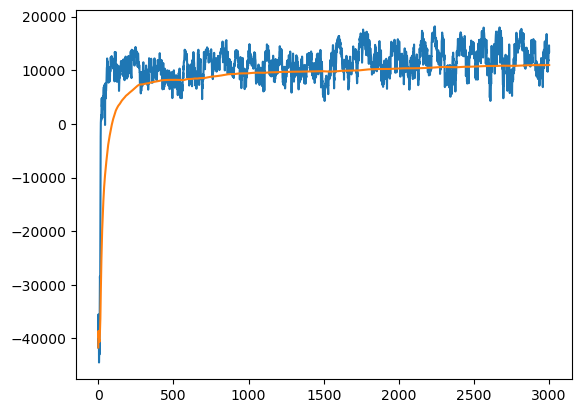

In [2]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 5000:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)